In [1]:
from app.rl.alpha_nine.v1.a9 import A9Model, convert_inputs
from gym_nine_mens_morris.envs.nine_mens_morris_env import NineMensMorrisEnv, Pix
import torch
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = A9Model(8, 4, 4, 4).double().to(device)

In [4]:
def subsample_legal_positions(probs, legal_pos):
    """
    probs: tensor of shape (24)
    legal_pos: list of tuples. Shape: (n, 3)
    """
    flattened_idx = [np.ravel_multi_index(pos, (3, 2, 4)) for pos in legal_pos]
    return probs[flattened_idx]


def sample_action(legal_actions, pos1, pos2, move, kill, is_phase_1, argmax=False):
    probs = []

    legal_pos = list(set([action[0] for action in legal_actions]))  # [(3, 2, 4), (3, 2, 4), ... ]
    pos_probs_ = pos1 if is_phase_1 else pos2
    # subsample pos_probs with legal actions
    pos_probs = subsample_legal_positions(pos_probs_, legal_pos)
    pos_idx = int(pos_probs.argmax()) if argmax else int(torch.multinomial(pos_probs, 1).squeeze())  # 24
    pos = legal_pos[pos_idx]  # (3, 2, 4)
    probs.append(pos_probs[pos_idx])

    # [0, 1, 2, 3]
    legal_moves = list(
        set([action[1] for action in legal_actions if tuple(action[0]) == tuple(pos) and action[1] is not None]))
    if len(legal_moves) != 0:
        move = move[legal_moves]
        move_idx = int(move.argmax()) if argmax else int(torch.multinomial(move, 1).squeeze())  # 4
        move_ = legal_moves[move_idx]  # 4
        probs.append(move[move_idx])
    else:
        move_ = None

    legal_kills = list(
        set([tuple(action[2]) for action in legal_actions if tuple(action[0]) == tuple(pos) and action[2] is not None]))
    if len(legal_kills) != 0:
        kill = subsample_legal_positions(kill, legal_kills)
        kill_idx = int(kill.argmax()) if argmax else int(torch.multinomial(kill, 1).squeeze())
        kill_ = legal_kills[kill_idx]  # (3, 2, 4)
        probs.append(kill[kill_idx])
    else:
        kill_ = None

    return (pos, move_, kill_), torch.mean(torch.stack(probs))


def reset_opponent_model(opponent, prev_models):
    prev_models = prev_models[-20:]
    prev_models.append(copy.deepcopy(model))
    opponent.model = prev_models[np.random.choice(len(prev_models), 1)[0]]
    opponent.model.eval()
    return prev_models


def play(player_1, player_2, render=False):
    env = NineMensMorrisEnv()
    env.reset()
    if render:
        env.render()

    info = {}
    is_done = False
    while not is_done:
        player = player_1 if env.player == Pix.W else player_2
        state, reward, is_done, info = env.step(player(env))
        if render:
            env.render()

    winner = info.get('winner')
    if winner:
        return 1 if winner == Pix.W.string else 2
    return 0


def random_player(env, legal_actions=None):
    legal_actions = legal_actions if legal_actions is not None else env.get_legal_actions()
    if len(legal_actions) == 0:
        env.swap_players()
        return (0, 0, 0), None, None
    random_idx = int(torch.randint(low=0, high=len(legal_actions), size=(1,))[0])
    random_action = legal_actions[random_idx]
    return random_action


class AIPlayer:
    def __init__(self, model):
        self.model = model

    def __call__(self, env, legal_actions=None):
        legal_actions = legal_actions if legal_actions is not None else env.get_legal_actions()
        if len(legal_actions) == 0:
            env.swap_players()
            return (0, 0, 0), None, None

        xs = create_state_batch([env])

        was_train = self.model.training

        self.model.eval()
        with torch.no_grad():
            yh_pos_1, yh_pos_2, yh_move, yh_kill = self.model(xs)  # yh shape: (batch, 9)

        if was_train:
            self.model.train()

        action, _ = sample_action(legal_actions, yh_pos_1[0], yh_pos_2[0], yh_move[0], yh_kill[0],
                                  env.is_phase_1(), argmax=False)

        return action


def randomize_ai_player(stats):
    batch_size = len(stats)

    # First half are False and second half are True
    bools = torch.arange(batch_size) > (batch_size - 1) / 2

    # Randomly shuffle equal number of Falses and Trues
    bools = bools[torch.randperm(batch_size)]

    # Set player's piece to these random values
    for i in range(batch_size):
        stats[i].player = Pix.W if bools[i] else Pix.B


def create_state_batch(envs):
    xs = [convert_inputs(env.board, env.player) for env in envs]
    xs = torch.stack(xs).long().to(device)
    return xs


def is_all_done(stats):
    for stat in stats:
        if not stat.env.is_done:
            return False
    return True


def get_credits(t, gamma):
    credits = []
    prev_credit = 1
    for i in range(t):
        credits.append(prev_credit)
        prev_credit *= gamma
    return torch.tensor(list(reversed(credits))).double().to(device)


def get_returns(rewards, gamma):
    total_t = len(rewards)
    returns = []
    prev_return = 0
    for t in range(total_t):
        prev_return = rewards[total_t - t - 1] + (gamma * prev_return)
        returns.append(prev_return)
    return torch.tensor(list(reversed(returns))).double().to(device)


def get_loss(stats):
    loss = 0
    for i_env in range(len(stats)):

        returns = get_returns(stats[i_env].rewards, gamma=0.99)
        probs = torch.log(torch.stack([prob for prob in stats[i_env].probs]))
        credits = get_credits(len(stats[i_env].rewards), gamma=0.99)

        loss += torch.mean(probs * credits * returns)
    return -1 * loss / len(stats)


class Stat:
    def __init__(self):
        self.player = Pix.W
        self.env = NineMensMorrisEnv()
        self.steps = []
        self.has_won = None
        self.probs = []
        self.rewards = []

        self.env.reset()


class EpisodicStat:
    def __init__(self, batch_size):
        self.loss = None
        self.stats = [Stat() for _ in range(batch_size)]


def plot_interval(stats, episode_number):
    losses = [stat.loss for stat in stats]

    print(f'{episode_number}: {np.mean(losses)}', end='\t')

    wins, loses, plays = 0, 0, 0
    for stat_ep in stats:
        for stat_t in stat_ep.stats:
            plays += 1
            if stat_t.has_won:
                wins += 1
            else:
                loses += 1

    print(f'W: {wins / plays * 100} L: {loses / plays * 100} P: {plays}')

    plt.plot(losses)
    plt.show()


def run_time_step(stats, opponent):
    xs = create_state_batch([stat.env for stat in stats])

    yh = model(xs)
    with torch.no_grad():
        yh_op = opponent.model(xs)

    for i in range(len(stats)):
        if not stats[i].env.is_done:
            env = stats[i].env

            legal_actions = env.get_legal_actions()
            if len(legal_actions) == 0:
                env.swap_players()
                continue

            # Is current player AI or other?
            if env.player == stats[i].player:
                action, prob = sample_action(legal_actions, yh[0][i], yh[1][i], yh[2][i], yh[3][i], env.is_phase_1())
                state, reward, is_done, info = env.step(action)

                stats[i].probs.append(prob)
                stats[i].rewards.append(reward)
            else:
                action, _ = sample_action(legal_actions, yh_op[0][i], yh_op[1][i], yh_op[2][i], yh_op[3][i],
                                          env.is_phase_1())
                _, _, is_done, info = env.step(action)

            if is_done:
                stats[i].has_won = stats[i].player.string == info.get('winner')


def train():
    batch_size = 16
    episodes = 100
    reset_length = 20
    episodic_stats = []
    prev_models = []

    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=1e-4)
    opponent = AIPlayer(copy.deepcopy(model))
    opponent.model.eval()

    for episode in range(episodes):
        stat_ep = EpisodicStat(batch_size)

        randomize_ai_player(stat_ep.stats)

        # Monte Carlo loop
        while not is_all_done(stat_ep.stats):
            run_time_step(stat_ep.stats, opponent)

        loss = get_loss(stat_ep.stats)

        optim.zero_grad()
        loss.backward()
        optim.step()

        stat_ep.loss = loss.item()
        episodic_stats.append(stat_ep)
        print('.', end='')

        if (episode + 1) % reset_length == 0:
            plot_interval(episodic_stats, episode)
            episodic_stats = []
            prev_models = reset_opponent_model(opponent, prev_models)


....................19: 74.214644308949	W: 50.0 L: 50.0 P: 320
....................39: 74.65529616993787	W: 50.9375 L: 49.0625 P: 320
....................59: 67.9769391255434	W: 51.5625 L: 48.4375 P: 320
....................79: 72.68234546171351	W: 50.625 L: 49.375 P: 320
....................99: 73.56237301195793	W: 49.6875 L: 50.31250000000001 P: 320


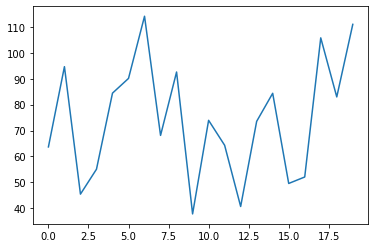

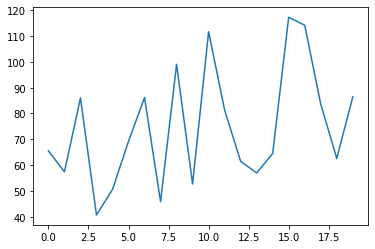

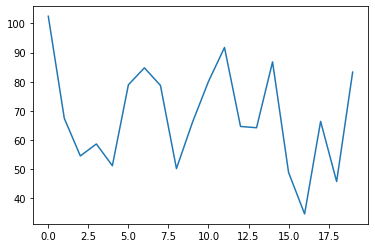

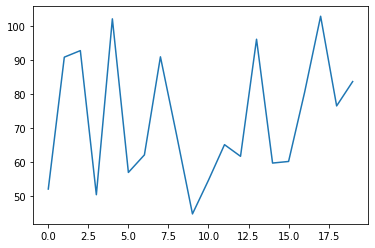

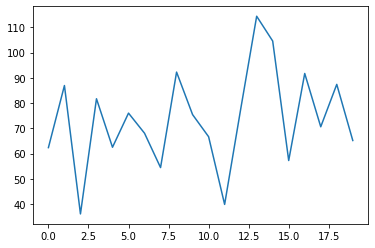

In [5]:
train()

In [6]:
plays = [play(AIPlayer(model), random_player) for _ in range(100)]
winners = torch.tensor(plays).float()

draws = len(torch.nonzero(winners == 0))
wins = len(torch.nonzero(winners == 1))
loses = len(torch.nonzero(winners == 2))

draws, wins, loses

(0, 5, 95)

In [7]:
plays = [play(random_player, AIPlayer(model)) for _ in range(100)]
winners = torch.tensor(plays).float()

draws = len(torch.nonzero(winners == 0))
wins = len(torch.nonzero(winners == 1))
loses = len(torch.nonzero(winners == 2))

draws, wins, loses

(0, 90, 10)

In [11]:
play(random_player, AIPlayer(model), render=True)

Current Player: W
[9 9 0 0]

•-----•-----•
| •---•---• |
| | •-•-• | |
•-•-•   •-•-•
| | •-•-• | |
| •---•---• |
•-----•-----•

Current Player: B
[8 9 0 0]

•-----•-----•
| •---•---• |
| | •-•-• | |
•-•-•   •-•-•
| | •-•-• | |
| •---•---• |
•-----W-----•

Current Player: W
[8 8 0 0]

•-----•-----•
| •---•---• |
| | •-•-• | |
B-•-•   •-•-•
| | •-•-• | |
| •---•---• |
•-----W-----•

Current Player: B
[7 8 0 0]

•-----•-----•
| •---W---• |
| | •-•-• | |
B-•-•   •-•-•
| | •-•-• | |
| •---•---• |
•-----W-----•

Current Player: W
[7 7 0 0]

•-----•-----•
| •---W---• |
| | •-•-• | |
B-•-•   •-•-•
| | •-•-• | |
| •---•---• |
B-----W-----•

Current Player: B
[6 7 0 0]

W-----•-----•
| •---W---• |
| | •-•-• | |
B-•-•   •-•-•
| | •-•-• | |
| •---•---• |
B-----W-----•

Current Player: W
[6 6 0 0]

W-----•-----•
| •---W---• |
| | •-•-• | |
B-•-•   •-•-B
| | •-•-• | |
| •---•---• |
B-----W-----•

Current Player: B
[5 6 0 0]

W-----•-----•
| •---W---• |
| | •-•-• | |
B-•-•   •-•-B
| | •-•-• | |
| •--

1

In [9]:
play(random_player, random_player, render=True)

Current Player: W
[9 9 0 0]

•-----•-----•
| •---•---• |
| | •-•-• | |
•-•-•   •-•-•
| | •-•-• | |
| •---•---• |
•-----•-----•

Current Player: B
[8 9 0 0]

•-----•-----•
| •---•---• |
| | •-W-• | |
•-•-•   •-•-•
| | •-•-• | |
| •---•---• |
•-----•-----•

Current Player: W
[8 8 0 0]

•-----•-----•
| •---•---• |
| | •-W-• | |
•-•-•   •-•-•
| | •-B-• | |
| •---•---• |
•-----•-----•

Current Player: B
[7 8 0 0]

W-----•-----•
| •---•---• |
| | •-W-• | |
•-•-•   •-•-•
| | •-B-• | |
| •---•---• |
•-----•-----•

Current Player: W
[7 7 0 0]

W-----•-----•
| •---•---• |
| | •-W-• | |
•-•-B   •-•-•
| | •-B-• | |
| •---•---• |
•-----•-----•

Current Player: B
[6 7 0 0]

W-----•-----•
| •---W---• |
| | •-W-• | |
•-•-B   •-•-•
| | •-B-• | |
| •---•---• |
•-----•-----•

Current Player: W
[6 6 0 0]

W-----•-----•
| •---W---• |
| | •-W-• | |
•-•-B   •-B-•
| | •-B-• | |
| •---•---• |
•-----•-----•

Current Player: B
[5 6 0 0]

W-----•-----•
| •---W---• |
| | •-W-W | |
•-•-B   •-B-•
| | •-B-• | |
| •--

1

In [10]:
[0.99 ** i for i in range(100)]


[1.0,
 0.99,
 0.9801,
 0.970299,
 0.96059601,
 0.9509900498999999,
 0.941480149401,
 0.9320653479069899,
 0.9227446944279201,
 0.9135172474836408,
 0.9043820750088044,
 0.8953382542587164,
 0.8863848717161292,
 0.8775210229989678,
 0.8687458127689782,
 0.8600583546412884,
 0.8514577710948755,
 0.8429431933839268,
 0.8345137614500875,
 0.8261686238355866,
 0.8179069375972308,
 0.8097278682212584,
 0.8016305895390459,
 0.7936142836436554,
 0.7856781408072188,
 0.7778213593991467,
 0.7700431458051551,
 0.7623427143471035,
 0.7547192872036326,
 0.7471720943315961,
 0.7397003733882802,
 0.7323033696543975,
 0.7249803359578534,
 0.7177305325982749,
 0.7105532272722921,
 0.7034476949995692,
 0.6964132180495735,
 0.6894490858690777,
 0.682554595010387,
 0.6757290490602831,
 0.6689717585696803,
 0.6622820409839835,
 0.6556592205741436,
 0.6491026283684022,
 0.6426116020847181,
 0.6361854860638709,
 0.6298236312032323,
 0.6235253948912,
 0.617290140942288,
 0.611117239532865,
 0.6050060671375364